In [48]:
import pandas as pd
import numpy as np
import re
from subprocess import Popen
from os.path import isfile
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [49]:
def create_assembly_column_for_dataframe(df):
    def get_assembly(line):
        gcf_regex = re.compile("GCF_[0-9]*\.[0-9]")
        res = re.search(gcf_regex,line)
        return res.group()

    df['assembly'] = df['sseqid'].apply(lambda line: get_assembly(line))
    return df

In [50]:
def slice_blast_dataframe_based_on_protein_ids(protein_ids,df):
    try:
        print("[*] START parsing BLAST result dataframe")
        dataframes = []
        for qseq in eps_operon_important_genes:
            if qseq in list(df['qseqid'].unique()):
                dataframes.append(df[df['qseqid'] == qseq].copy())
                print("\t[+] appended dataframe with orthologs to {}".format(qseq))
            else:
                print("[-] {} not in result dataframe ...".format(qseq))

        df = pd.concat(dataframes)
        print("[+] DONE parsing, amount dataframes : {}".format(len(dataframes)))
        return dataframes,df
    except Exception as e:
        print("[-] ERROR during parsing of dataframes")
        raise Exception("[-] ERROR during parsing of dataframes for slicing BLAST df into qseqid dataframes")

In [51]:
def build_ortholog_count_dictionary(dataframes):
    print("[*] Start parsing of dataframes")
    full_operon_hits = {}
    count = 1
    try:
        for dataf in dataframes:
            #print("[*] Parsing pandas dataframe : {}".format(count))
            for assembly in list(dataf['assembly'].unique()):
                if assembly not in full_operon_hits.keys():
                    full_operon_hits[assembly] = 1
                    continue
                else:
                    full_operon_hits[assembly] += 1
                    continue
            print('\t[+] Done parsing df of qseqid {} : number in queue {}'.format(str(dataf['qseqid'].unique()[0]),count))
            count += 1
        print("[+] DONE parsing")
        return full_operon_hits
    except Exception as e:
        print("[-] ERROR during parsing of dataframes")
        raise Exception("[-] ERROR during parsing of dataframes for building full_operon_hits dictionary")

In [52]:
def fetch_assemblies_with_defined_ortholog_threshold(full_operon_hits,amount_of_orthologs):
    target_assemblies = []
    print("[*] START parsing full_operon_hit dictionary with defined ortholog threshold of {}".format(amount_of_orthologs))
    for hit in full_operon_hits.keys():
        if full_operon_hits[hit] >= amount_of_orthologs:
            target_assemblies.append(hit)
            #print("\t[+] found : {}".format(hit))
    print("[+] Found {} assemblies with >= {} amount of orthologs".format(len(target_assemblies),amount_of_orthologs))
    return target_assemblies

In [53]:
def parse_blast_df_based_on_target_assemblies(target_assemblies,df):
    try:
        print("[*] START recreating blast dataframe based on target assemblies")
        result_dataframes = []
        for hit in target_assemblies:
            result_dataframes.append(df[df['assembly'] == hit])
        result_df = pd.concat(result_dataframes)
        print("[+] DONE parsing, return dataframe with target assemblies")
        return result_df
    except Exception as e:
        print("[-] ERROR during blast dataframe parsing")
        raise Exception("[-] ERROR during parsing of blast dataframe with target assembly accessions")

In [54]:
def read_refseq_summary_file_and_build_result_df(target_assemblies, result_df,refseq_summary_filepath='../refseq_summary/assembly_summary_refseq.txt'):
    try:
        print("[*] START reading refseq summary file : {}".format(refseq_summary_filepath))
        refseq_table = pd.read_table(refseq_summary_filepath, skiprows=[0, 1], header=None, usecols=range(22))
        header = ["assembly_accession", "bioproject", "biosample", "wgs_master", "refseq_category", "taxid",
                  "species_taxid", "organism_name", "infraspecific_name", "isolate", "version_status", "assembly_level",
                  "release_type", "genome_rep", "seq_rel_date", "asm_name", "submitter", "gbrs_paired_asm",
                  "paired_asm_comp", "ftp_path", "excluded_from_refseq", "relation_to_type_material"]
        refseq_table.columns = header
        print("[+] DONE")
        print("[*] START extracting target assemblies")
        target_refseq_assemblies = []
        for assembly_acc in target_assemblies:
            target_refseq_assemblies.append(refseq_table[refseq_table['assembly_accession'] == assembly_acc])
        assemblies_pd = pd.concat(target_refseq_assemblies)
        print('[+] DONE')
        
        def set_ftp_path_for_genbank_gbff_file(ftp_path):
            assembly = ftp_path.split('/')[-1:][0]
            assembly = ftp_path + '/' + str(assembly) + '_genomic.gbff.gz'
            return assembly

        print("[*] START merging refseq table with filtered blast dataframe")
        refseq_table = assemblies_pd[['assembly_accession', 'organism_name', 'taxid', 'species_taxid','assembly_level', 'ftp_path']].copy()
        refseq_table['ftp_path'] = refseq_table['ftp_path'].apply(lambda row: set_ftp_path_for_genbank_gbff_file(row))

        merge_df = result_df.copy()
        merge_df = merge_df.drop_duplicates(['assembly'],keep="last")
        merge_df["taxid"] = merge_df['staxids']
        refseq_table = pd.merge(refseq_table,merge_df,on='taxid')
        refseq_table = refseq_table.sort_values(by=['genus'])
        print("[+] DONE")
        return refseq_table
    except Exception as e:
        print("[-] ERROR during parsing of refseq table")
        raise Exception("[-] ERROR during parsing of refseq table with target assemblies with Excpetion : {}".format(e))


In [55]:
def download_assemblies(refseq_table):
    print("[*] START download procedure")
    for ftp_path, organism_name, assembly in zip(refseq_table['ftp_path'],refseq_table['organism_name'],refseq_table["assembly_accession"]):
        gunzip_output = organism_name.replace(".","").replace(" ","_")+assembly+'.gbk'
        if isfile(gunzip_output) == False:
            for attempt in range(10):

                try:

                    proc = Popen('wget -qO- {} | gzip -d > {}'.format(ftp_path, gunzip_output), shell=True)
                    returncode = proc.wait(timeout=300)  # 66 Minutes

                    if(returncode != 0):
                        raise Exception

                #catch exception raised if the subproccess failed e.g. gzip failure due to invalid download
                except Exception as e:
                    print("\t\t[-] ERROR")
                    if(attempt == 9):
                        if(isfile(gunzip_output) == True):
                            remove(path_to_database + gunzip_output)
                            print("\t\t[*]removed empty file: {}".format(gunzip_output))
                else:
                    if returncode == 0:
                        print("\t[+] Downloaded GBFF file for : {}".format(gunzip_output))
                    else:
                        print("[-] Unconventional ERROR ocurred ...")
                    break    
        else:
            print("\t[+] File exists: {}".format(gunzip_output))
    print("[+] DONE downloading")

In [56]:
def get_positional_informations_for_subject_sequences(gbfile,assembly,result_df):
    try:
        records = []
        for record in SeqIO.parse(gbfile,'genbank'):
            #print(record.id,len(record))
            records.append(record)
        print("[*] Parsed GeneBank-File records: {}".format(len(records)))
        transient_df = result_df[result_df['assembly'] == assembly]
        target_prot_ids = list(transient_df['sacc'].unique())
        locus_tags = []
        qseqids = []
        cds_counter = 0

        orthologous_gene_ids = []
        gbseq_location = []
        gene_order = []
        general_count = 0

        gbfile_counter = 0

        while gbfile_counter < len(records):
            gbfile = records[gbfile_counter]
            print("[*] Start extracting information of GBFF-File : {}".format(gbfile_counter+1))
            for feature in gbfile.features:
                if 'protein_id' in feature.qualifiers.keys():
                    prot_id = feature.qualifiers['protein_id'][0].split('.')[0]
                    cds_counter += 1
                    general_count += 1
                    if prot_id in target_prot_ids:
                        try:
                            if len(result_df.loc[result_df['sacc'] == prot_id]['qseqid']) > 1:
                                orthologous_gene = list(result_df.loc[result_df['sacc'] == prot_id]['qseqid'])[0]
                            else:
                                orthologous_gene = result_df.loc[result_df['sacc'] == prot_id]['qseqid'].item()

                            orthologous_gene_ids.append(orthologous_gene)
                            gbseq_location.append([prot_id,cds_counter,feature.location,])
                            gene_order.append(cds_counter)
                        except:
                            print("\t[-] {}".format(prot_id))
                            print("\t[-] {}".format(len(result_df.loc[result_df['sacc'] == prot_id]['qseqid'].item())))
                            continue

            gbfile_counter += 1

        print("[+] length of filtered genes",len(gene_order),len(target_prot_ids))
        return general_count,gene_order,gbseq_location,orthologous_gene_ids, len(target_prot_ids)
    except Exception as e:
        print("[-] ERROR during parsing of genbank files with Exception : {}".format(e))

In [57]:
def parse_genbank_files(refseq_table):
    position_list = []
    for organism_name,assembly_accession in zip(refseq_table['organism_name'],refseq_table['assembly_accession']):
        gunzip_output = organism_name.replace(".","").replace(" ","_")+assembly_accession+'.gbk'
        if isfile(gunzip_output):
            print("[*] GeneBank-File: ",gunzip_output," Assembly Accession: ", assembly_accession)
            try:
                result = get_positional_informations_for_subject_sequences(gunzip_output,assembly_accession,result_df)
                position_list.append([organism_name,result[0],result[1],result[3], result[-1]])
                print("\t[+] Done Parsing")
            except Exception as e:
                print("[-] Exception : {}".format(e))
                continue
    return position_list

In [58]:
def parse_position_list_and_prepare_data_for_plotting(position_list):
    print("[*] START building plot data")
    try:
        def extract_x_data(loc_listing):    
            x_data = []
            normalizer = 100/loc_listing[1]
            for loc in loc_listing[2][0:]:
                x_data.append(loc*normalizer)
            return x_data

        eps_operon = list(result_df['qseqid'].unique())
        eps_dict = {}
        counter = 1
        for gene in eps_operon:
            eps_dict[gene] = counter
            counter += 1

        x_data_general = []
        x_data_orthologs = []
        y_tick_labels = []
        right_y_axis_tick_labels = []
        for loc_list in position_list:
            label = loc_list[0]
            if len(label) > 30:
                label = ' '.join(label.split(' ')[0:2])
            y_tick_labels.append(label)
            x_orth = []
            right_y_axis_tick_labels.append(loc_list[-1])
            for ort in loc_list[3]:
                x_orth.append(eps_dict[ort])
            x_data_orthologs.append(x_orth)
            x_data_general.append(extract_x_data(loc_list))
        print("[+] DONE")
        return x_data_general, x_data_orthologs, y_tick_labels, right_y_axis_tick_labels
    except Exception as e:
        raise Exception("[-] ERROR building data for plotting with Exception : {}".format(e))

In [71]:
#divide the result dataframe into subframes with query ids
eps_operon_important_genes = ['WP_087496534',
 'WP_087496535',
 'WP_087496536',
 'WP_087496537',
 'WP_087496538',
 'WP_198301847',
 'WP_198301974',
 'WP_087496542',
 'WP_157673201',
 'WP_087496544',
 'WP_087496545',
 'WP_087496546',
 'WP_087496547',
 'WP_087496548',
 'WP_157673202',
 'WP_087496550',
 'WP_087496551',
 'WP_087496552',
 'WP_087496553',
 'WP_087496554',
 'WP_087496555',
 'WP_087496556',
 'WP_087496557',
 'WP_087496558',
 'WP_087496559',
 'WP_087496560',
 'WP_087496561',
 'WP_087496562',
 'WP_087496563',
 'WP_087496564']

eps_operon_important_genes = [
 'WP_087496556',
 'WP_087496557',
 'WP_087496558',
 'WP_087496559',
 'WP_087496560',
 'WP_087496561',
 'WP_087496562',
 'WP_087496563',
 'WP_087496564']

eps_operon_important_genes = ['WP_087496534',
 'WP_087496535',
 'WP_087496536',
 'WP_087496537',
 'WP_087496538',
 'WP_198301847',
 'WP_198301974',
 'WP_087496542',
 'WP_157673201',
 'WP_087496544',
 'WP_087496545',
 'WP_087496546',
 'WP_087496547',
 'WP_087496548',
 'WP_157673202',
 'WP_087496550',
 'WP_087496551',
 'WP_087496552',
 'WP_087496553',
 'WP_087496554',
 'WP_087496555',]


eps_operon_important_genes = ['WP_087496534',
 'WP_087496535',
 'WP_087496536',
 'WP_087496537',
 'WP_087496538',
 'WP_198301847',
 'WP_198301974',
 'WP_087496542',
 'WP_157673201',
 'WP_087496544',
 'WP_087496545',
 'WP_087496546',
 'WP_087496547',
 'WP_087496548',
 'WP_157673202',
 'WP_087496550',
 'WP_087496551',
 'WP_087496552',
 'WP_087496553',
 'WP_087496554',
 'WP_087496555',
 'WP_087496556',
 'WP_087496557',
 'WP_087496558',
 'WP_087496559',
 'WP_087496560',
 'WP_087496561',
 'WP_087496562',
 'WP_087496563',
 'WP_087496564']

eps_operon_important_genes = ['WP_087496534',
 'WP_087496535',
 'WP_087496536',
 'WP_087496537',]

eps_operon_important_genes = [
'WP_087496556',
 'WP_087496557',
 'WP_087496558',
 'WP_087496559',
 'WP_087496560',
 'WP_087496561',
 'WP_087496562',
 'WP_087496563',
 'WP_087496564']

df = pd.read_csv('eps_operon_full.csv',index_col=0,header=0)
df = create_assembly_column_for_dataframe(df)

#parsing blast result dataframe
dataframes,df = slice_blast_dataframe_based_on_protein_ids(eps_operon_important_genes,df)
full_operon_hits = build_ortholog_count_dictionary(dataframes)

#find assemblies with specific amount of orthologous hits
target_assemblies = fetch_assemblies_with_defined_ortholog_threshold(full_operon_hits,9)
result_df = parse_blast_df_based_on_target_assemblies(target_assemblies,df)

#downloading genbank files
refseq_table = read_refseq_summary_file_and_build_result_df(target_assemblies, result_df)
download_assemblies(refseq_table)

#parsing genbank files
position_list = parse_genbank_files(refseq_table)
x_data_general, x_data_orthologs, y_tick_labels, right_y_axis_tick_labels = parse_position_list_and_prepare_data_for_plotting(position_list)

[*] START parsing BLAST result dataframe
	[+] appended dataframe with orthologs to WP_087496556
	[+] appended dataframe with orthologs to WP_087496557
	[+] appended dataframe with orthologs to WP_087496558
	[+] appended dataframe with orthologs to WP_087496559
	[+] appended dataframe with orthologs to WP_087496560
	[+] appended dataframe with orthologs to WP_087496561
	[+] appended dataframe with orthologs to WP_087496562
	[+] appended dataframe with orthologs to WP_087496563
	[+] appended dataframe with orthologs to WP_087496564
[+] DONE parsing, amount dataframes : 9
[*] Start parsing of dataframes
	[+] Done parsing df of qseqid WP_087496556 : number in queue 1
	[+] Done parsing df of qseqid WP_087496557 : number in queue 2
	[+] Done parsing df of qseqid WP_087496558 : number in queue 3
	[+] Done parsing df of qseqid WP_087496559 : number in queue 4
	[+] Done parsing df of qseqid WP_087496560 : number in queue 5
	[+] Done parsing df of qseqid WP_087496561 : number in queue 6
	[+] Don

[*] Parsed GeneBank-File records: 3
[*] Start extracting information of GBFF-File : 1
[*] Start extracting information of GBFF-File : 2
[*] Start extracting information of GBFF-File : 3
[+] length of filtered genes 11 11
	[+] Done Parsing
[*] GeneBank-File:  Massilia_flavaGCF_009789595.1.gbk  Assembly Accession:  GCF_009789595.1
[*] Parsed GeneBank-File records: 1
[*] Start extracting information of GBFF-File : 1
[+] length of filtered genes 9 9
	[+] Done Parsing
[*] GeneBank-File:  Massilia_sp_YMA4GCF_003293715.1.gbk  Assembly Accession:  GCF_003293715.1
[*] Parsed GeneBank-File records: 1
[*] Start extracting information of GBFF-File : 1
[+] length of filtered genes 12 12
	[+] Done Parsing
[*] GeneBank-File:  Massilia_umbonataGCF_005280315.1.gbk  Assembly Accession:  GCF_005280315.1
[*] Parsed GeneBank-File records: 1
[*] Start extracting information of GBFF-File : 1
[+] length of filtered genes 13 13
	[+] Done Parsing
[*] GeneBank-File:  Massilia_putidaGCF_001941825.1.gbk  Assembly 

In [72]:
df = pd.read_csv('eps_operon_full.csv',index_col=0,header=0)
df = create_assembly_column_for_dataframe(df)

eps_operon_important_genes = ['WP_087496534',
 'WP_087496535',
 'WP_087496536',
 'WP_087496537',]

#parsing blast result dataframe
dataframes,df = slice_blast_dataframe_based_on_protein_ids(eps_operon_important_genes,df)
full_operon_hits = build_ortholog_count_dictionary(dataframes)

#find assemblies with specific amount of orthologous hits
#target_assemblies = fetch_assemblies_with_defined_ortholog_threshold(full_operon_hits,9)
result_df = parse_blast_df_based_on_target_assemblies(target_assemblies,df)

#downloading genbank files
refseq_table = read_refseq_summary_file_and_build_result_df(target_assemblies, result_df)
download_assemblies(refseq_table)

#parsing genbank files
position_list = parse_genbank_files(refseq_table)
x_data_general2, x_data_orthologs2, y_tick_labels2, right_y_axis_tick_labels2 = parse_position_list_and_prepare_data_for_plotting(position_list)

[*] START parsing BLAST result dataframe
	[+] appended dataframe with orthologs to WP_087496534
	[+] appended dataframe with orthologs to WP_087496535
	[+] appended dataframe with orthologs to WP_087496536
	[+] appended dataframe with orthologs to WP_087496537
[+] DONE parsing, amount dataframes : 4
[*] Start parsing of dataframes
	[+] Done parsing df of qseqid WP_087496534 : number in queue 1
	[+] Done parsing df of qseqid WP_087496535 : number in queue 2
	[+] Done parsing df of qseqid WP_087496536 : number in queue 3
	[+] Done parsing df of qseqid WP_087496537 : number in queue 4
[+] DONE parsing
[*] START recreating blast dataframe based on target assemblies
[+] DONE parsing, return dataframe with target assemblies
[*] START reading refseq summary file : ../refseq_summary/assembly_summary_refseq.txt
[+] DONE
[*] START extracting target assemblies
[+] DONE
[*] START merging refseq table with filtered blast dataframe
[+] DONE
[*] START download procedure
	[+] File exists: Azoarcus_sp_

[*] Parsed GeneBank-File records: 1
[*] Start extracting information of GBFF-File : 1
[+] length of filtered genes 4 4
	[+] Done Parsing
[*] GeneBank-File:  Massilia_putidaGCF_001941825.1.gbk  Assembly Accession:  GCF_001941825.1
[*] Parsed GeneBank-File records: 3
[*] Start extracting information of GBFF-File : 1
[*] Start extracting information of GBFF-File : 2
[*] Start extracting information of GBFF-File : 3
[+] length of filtered genes 4 4
	[+] Done Parsing
[*] GeneBank-File:  Methylobacillus_flagellatus_KTGCF_000013705.1.gbk  Assembly Accession:  GCF_000013705.1
[*] Parsed GeneBank-File records: 1
[*] Start extracting information of GBFF-File : 1
[+] length of filtered genes 4 4
	[+] Done Parsing
[*] GeneBank-File:  Methylophilus_sp_TWE2GCF_001183865.1.gbk  Assembly Accession:  GCF_001183865.1
[*] Parsed GeneBank-File records: 1
[*] Start extracting information of GBFF-File : 1
[+] length of filtered genes 4 4
	[+] Done Parsing
[*] GeneBank-File:  Methylophilus_medardicusGCF_0063

# plotting

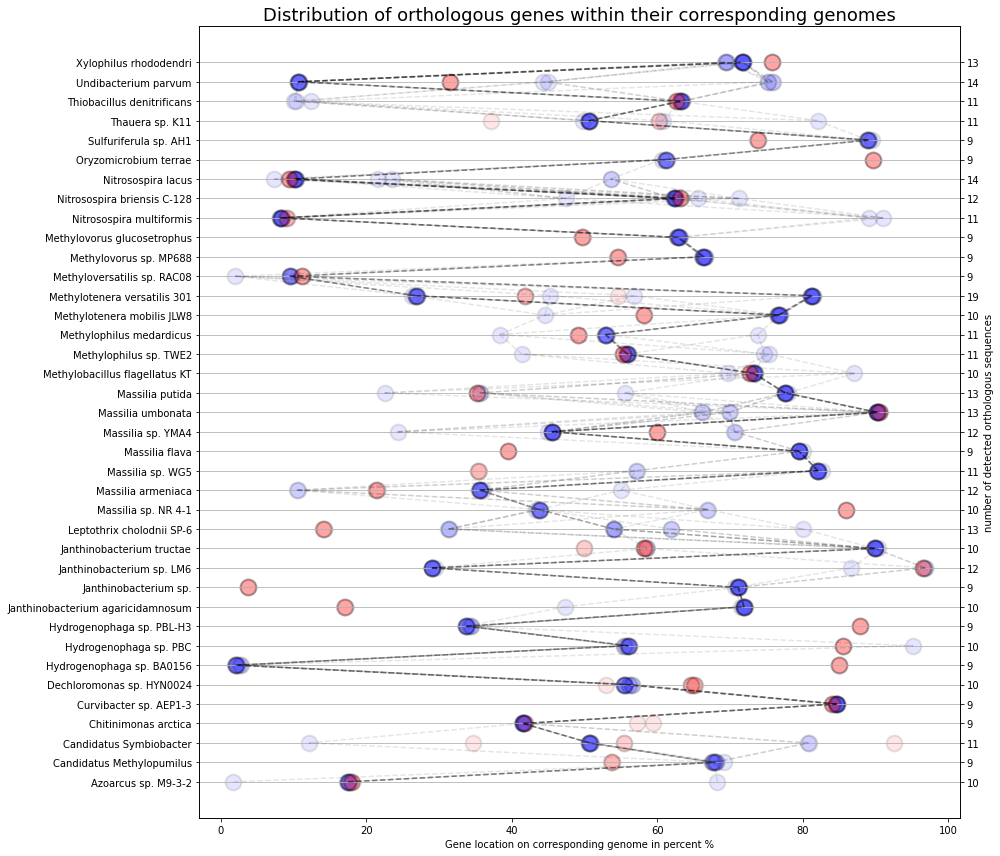

In [68]:
#fig = plt.figure(figsize=(12,8))
fig, axs = plt.subplots(figsize=(14,12))

twin1 = axs.twinx()

scatter_plots = []
counter = 0
for index,datapoints in enumerate(x_data_general):
    counter += 1
    x_data = datapoints
    y_data = [counter for datapoint in x_data]
    y_data2 = [counter for datapoint in x_data_general2[index]]
    ax = axs.scatter(y=y_data,x=x_data,s=250,alpha=0.1,edgecolors = "black",linewidths=2,color="blue")
    ax2 = axs.scatter(y=y_data2, x=x_data_general2[index],s=250,alpha=0.1,edgecolors = "black",linewidths=2,color="red")
    
    if index < len(x_data_general)-1:
        y_data_orthologs_plot = []
        for index_1,orth in enumerate(x_data_orthologs[counter-1]):
            for index_2,orth_hit in enumerate(x_data_orthologs[counter]):
                if orth == orth_hit:
                    #print(x_data_general[0][index_1])
                    y_data_orthologs_plot.append((x_data_general[counter-1][index_1],x_data_general[counter][index_2]))
        for data in y_data_orthologs_plot:
            plt.plot(data,[counter,counter+1],linestyle="dashed",c="black",alpha=0.1)
    
    #twin1 = axs.twinx()
    #ax2 = plt.scatter(x=[],y=[])
    #scatter_plots.append(ax)


#plt.xlim(0,100)
#plt.xticks(np.arange(0,100,1),rotation=90)
plt.grid()


yaxis_ticks = list(range(1,len(y_tick_labels)+1))

twin1.set_yticks(yaxis_ticks)
twin1.set_yticklabels(right_y_axis_tick_labels)
twin1.set_ylabel("number of detected orthologous sequences")
axs.set_yticks(yaxis_ticks)
axs.set_yticklabels(y_tick_labels)
axs.set_title("Distribution of orthologous genes within their corresponding genomes", fontsize=18)
axs.set_xlabel("Gene location on corresponding genome in percent %")
fig.tight_layout()
#plt.savefig("gene_locations_rhamnose_and_core_cluster_genes_38_organisms_with_X_orthologs.png",dpi=600)
plt.show()

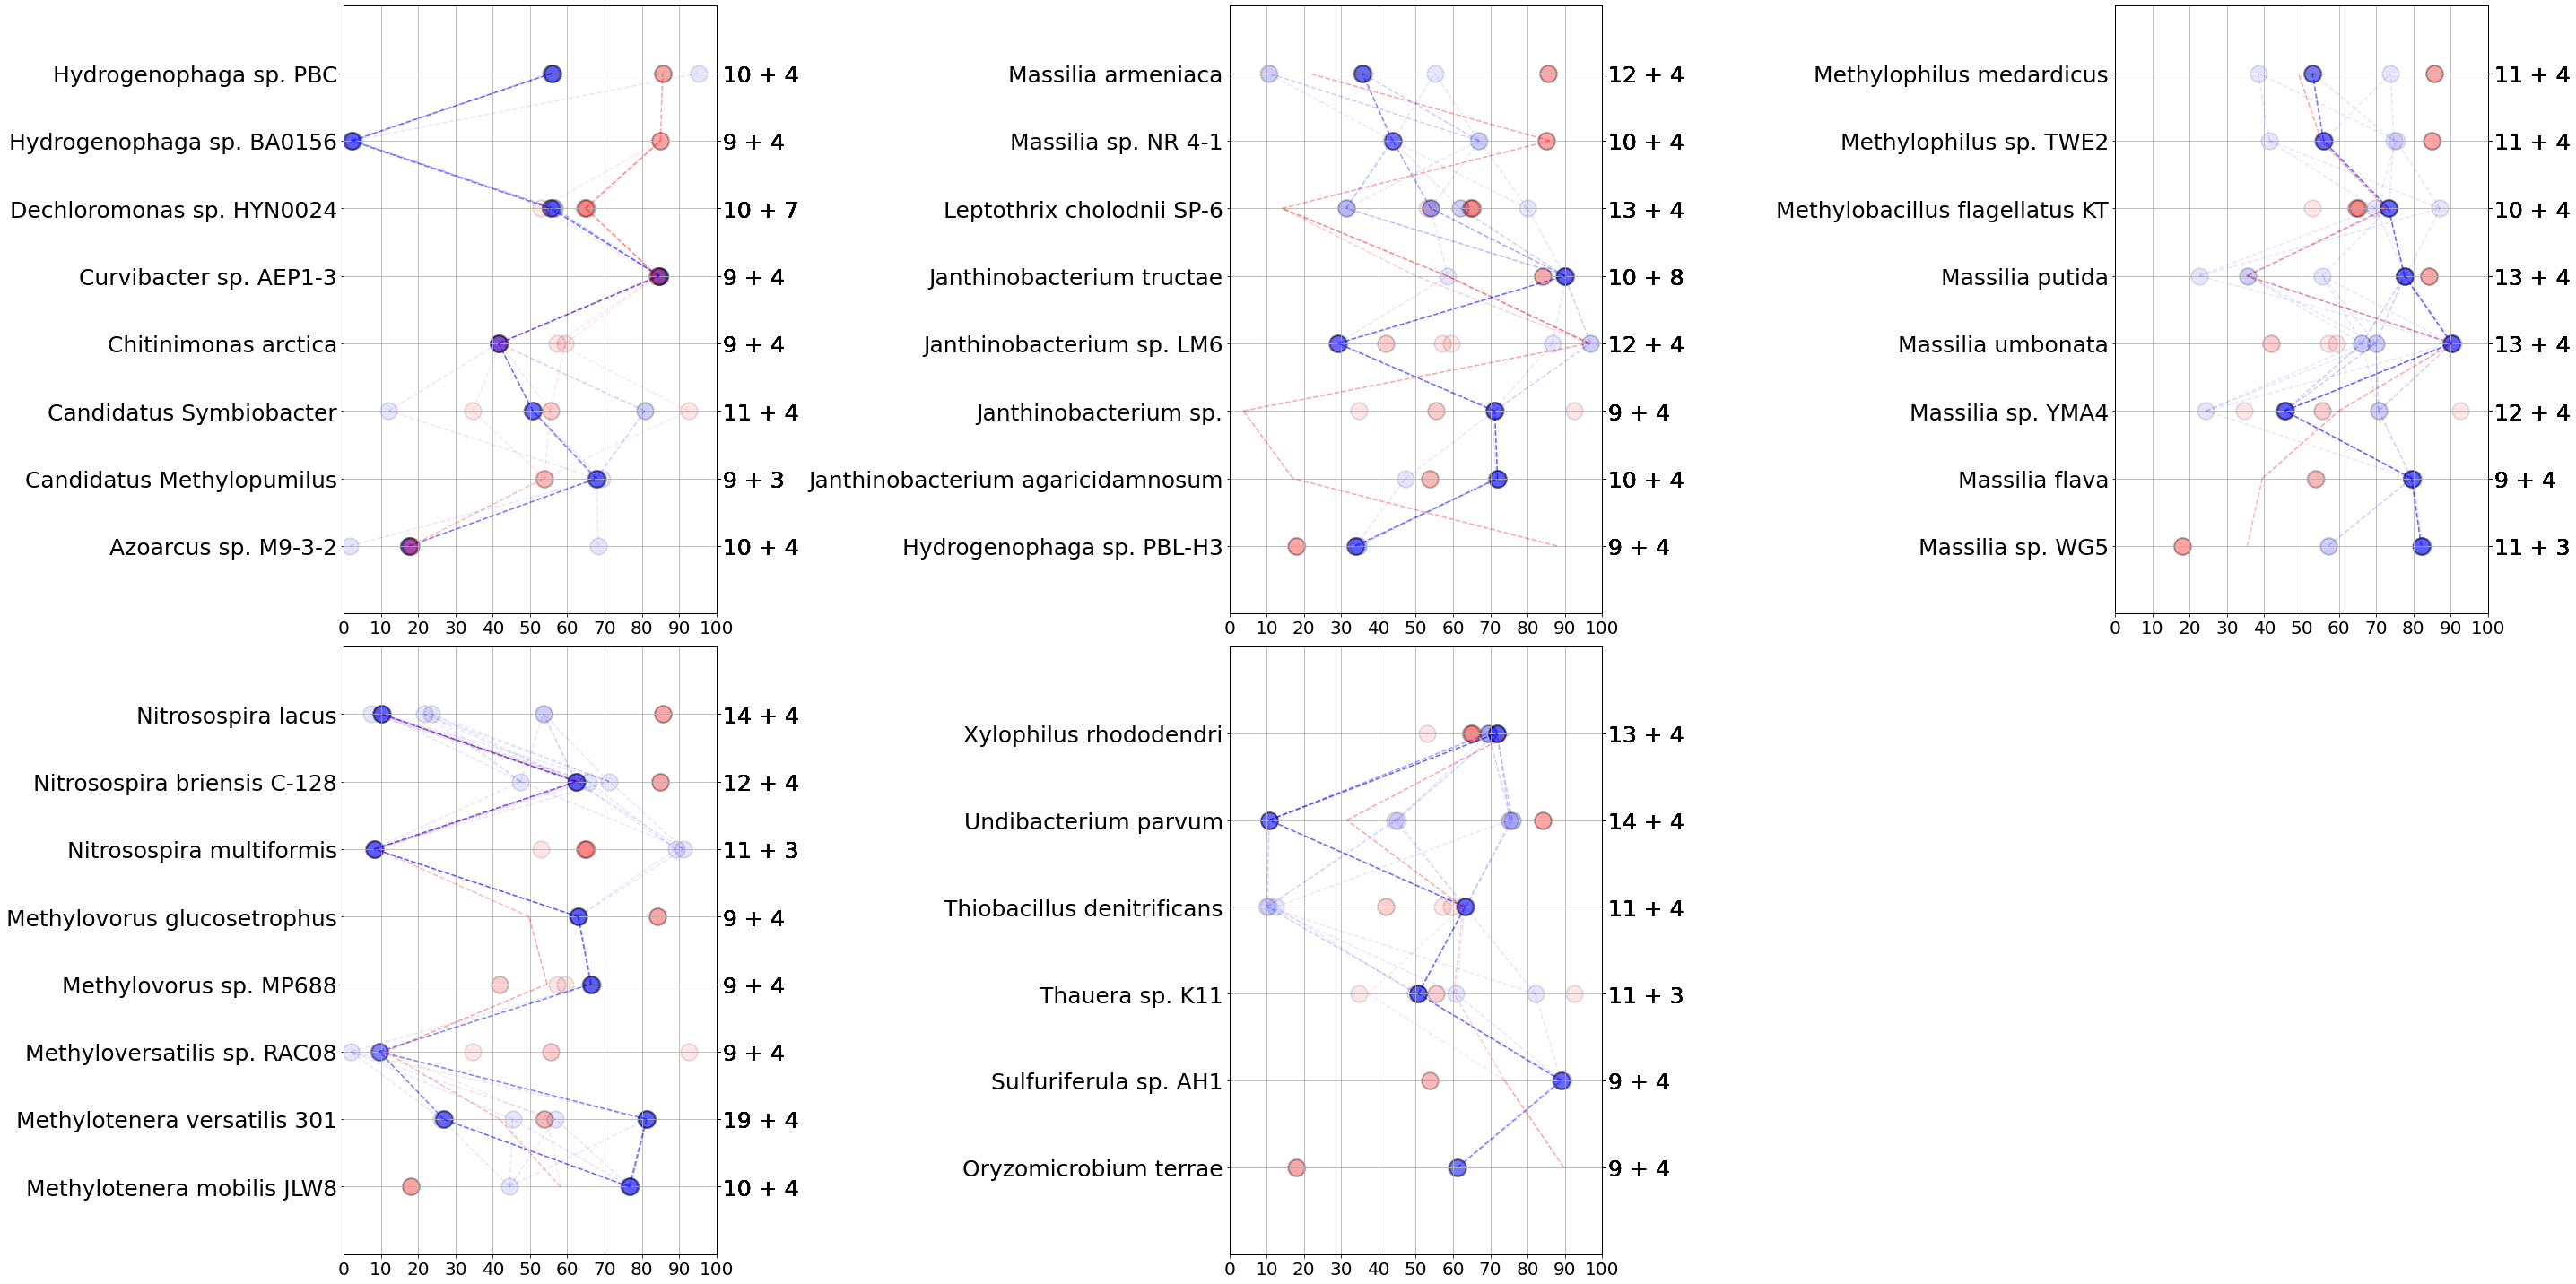

In [80]:
n_rows = 2
n_columns = 3
size = (40,20)
fsize=25
starter_list = [0,8,16,24,32]
end_list = [8,16,24,32,40]
max_organisms = 38
msize=350

fig, axs = plt.subplots(n_rows,n_columns,figsize=size)

#starter_list = [0,8,16,24,32,40,48,56,64,72,80,88,96,104,112,120]
#end_list = [8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,124]

subplot_row_counter = 0
subplot_column_counter = 0
subplot_counter = 0

line_counter = 0
line_plot_counter = 0
for start,end in zip(starter_list,end_list):
    counter = 0
    
    for index,datapoints in enumerate(x_data_general[start:end]):
        counter += 1
        line_plot_counter += 1
        x_data = datapoints
        y_data = [counter for datapoint in x_data]
        
        x_data2 = x_data_general2[index]
        y_data2 = [counter for datapoint in x_data2]
        right_y_labels = ["{} + {}".format(ry1,ry2) for ry1,ry2 in  zip(right_y_axis_tick_labels,right_y_axis_tick_labels2)]
        #print(right_y_labels)
        
        x_ticks = [0,10,20,30,40,50,60,70,80,90,100]
        y_ticks = list(range(1,len(y_tick_labels[0:len(x_data_general[start:end])])+1))
        #print(y_ticks)
        
            
        if n_rows != 1:
            
            
            axs[subplot_row_counter, subplot_column_counter].scatter(y=y_data,x=x_data,s=msize,alpha=0.1,edgecolors = "black",linewidths=2,color="blue")
            axs[subplot_row_counter, subplot_column_counter].scatter(y=y_data2,x=x_data2,s=msize,alpha=0.1,edgecolors = "black",linewidths=2,color="red")

            
            axs[subplot_row_counter, subplot_column_counter].set_yticks(y_ticks)
            axs[subplot_row_counter, subplot_column_counter].set_yticklabels(y_tick_labels[start:end],fontsize=fsize)
            axs[subplot_row_counter, subplot_column_counter].set_xlim(0,100)
            axs[subplot_row_counter, subplot_column_counter].set_ylim(0,len(y_tick_labels[start:end])+1)
            axs[subplot_row_counter, subplot_column_counter].grid(True)
            axs[subplot_row_counter, subplot_column_counter].set_xticks(x_ticks)
            axs[subplot_row_counter, subplot_column_counter].set_xticklabels(x_ticks,fontsize=20)
            
            twin = axs[subplot_row_counter,subplot_column_counter].twinx()
            twin.set_ylim(0,len(right_y_labels[start:end])+1)
            twin.set_yticks(y_ticks)
            twin.set_yticklabels(right_y_labels[start:end], fontsize=fsize)


            
            
        else:
            axs[subplot_column_counter].scatter(y=y_data,x=x_data,s=msize,alpha=0.1,edgecolors = "black",linewidths=2)
            axs[subplot_column_counter].set_yticks(range(1,len(y_tick_labels[0:len(x_data_general[start:end])])+1))
            axs[subplot_column_counter].set_yticklabels(y_tick_labels[start:end],fontsize=fsize)
            axs[subplot_column_counter].set_xlim(0,100)
            axs[subplot_column_counter].grid(True)
            twin = axs[subplot_column_counter].twinx()
            twin.set_ylim(0,len(y_tick_labels[start:end])+1)
            twin.set_yticks(y_ticks)
            twin.set_yticklabels(right_y_labels[start:end],fontsize=fsize)
            
        line_counter += 1
        if line_counter < 8 and line_plot_counter < max_organisms:
            y_data_orthologs_plot = []
            for index_1,orth in enumerate(x_data_orthologs[line_plot_counter-1]):
                for index_2,orth_hit in enumerate(x_data_orthologs[line_plot_counter]):
                    if orth == orth_hit:
                        #print(x_data_general[0][index_1])
                        #print(counter)
                        y_data_orthologs_plot.append((x_data_general[line_plot_counter-1][index_1],x_data_general[line_plot_counter][index_2]))
            for data in y_data_orthologs_plot:
                
                if n_rows != 1:
                    pass
                    axs[subplot_row_counter, subplot_column_counter].plot(data,[counter,counter+1],linestyle="dashed",c="blue",alpha=0.1)
                else:
                    pass
                    axs[subplot_column_counter].plot(data,[counter,counter+1],linestyle="dashed",c="black",alpha=0.1)
                    
            y_data_orthologs_plot2 = []
            for index_1,orth in enumerate(x_data_orthologs2[line_plot_counter-1]):
                for index_2,orth_hit in enumerate(x_data_orthologs2[line_plot_counter]):
                    if orth == orth_hit:
                        #print(x_data_general[0][index_1])
                        #print(counter)
                        y_data_orthologs_plot2.append((x_data_general2[line_plot_counter-1][index_1],x_data_general2[line_plot_counter][index_2]))
            for data in y_data_orthologs_plot2:
                if n_rows != 1:
                    pass
                    axs[subplot_row_counter, subplot_column_counter].plot(data,[counter,counter+1],linestyle="dashed",c="red",alpha=0.1)
                else:
                    pass
                    axs[subplot_column_counter].plot(data,[counter,counter+1],linestyle="dashed",c="black",alpha=0.1)
        else:
            line_counter = 0
            

    subplot_column_counter += 1
    subplot_counter += 1
    if subplot_counter == n_columns:
        subplot_counter = 0
        subplot_row_counter += 1
        subplot_column_counter = 0
        
#plt.xlim(0,100)
#plt.xticks(np.arange(0,100,1),rotation=90)
#plt.grid()
#plt.yticks(range(1,len(y_tick_labels)+1),y_tick_labels)
#plt.title("Distribution of orthologous genes within their corresponding genomes", fontsize=18)
#plt.xlabel("Gene location on corresponding genome in percent %")
#fig.suptitle('This is a somewhat long figure title', fontsize=16)
axs.flat[-1].set_visible(False)
fig.tight_layout()
#plt.savefig("gene_locations_38_organisms_rhamnose_and_core_eps_genes_subplots.png",dpi=600)
plt.show()

In [150]:
result_df['sscinames'].unique()

array(['Massilia umbonata', 'Rhodoferax sp. AJA081-3',
       'Oryzomicrobium terrae', 'Azoarcus sp. M9-3-2',
       'Curvibacter sp. AEP1-3', 'Janthinobacterium sp. 1_2014MBL_MicDiv',
       'Dechloromonas sp. HYN0024', 'Candidatus Symbiobacter mobilis CR',
       'Candidatus Methylopumilus turicensis',
       'Methyloversatilis sp. RAC08', 'Massilia putida',
       'Thiobacillus denitrificans ATCC 25259', 'Sulfuriferula sp. AH1',
       'Methylotenera versatilis 301', 'Undibacterium parvum',
       'Leptothrix cholodnii SP-6', 'Janthinobacterium sp. LM6',
       'Methylophilus sp. TWE2', 'Methylobacillus flagellatus KT',
       'Hydrogenophaga sp. BA0156', 'Massilia sp. NR 4-1',
       'Massilia flava', 'Nitrosospira briensis C-128',
       'Nitrosospira multiformis ATCC 25196', 'Hydrogenophaga sp. PBC',
       'Methylophilus medardicus', 'Massilia sp. WG5',
       'Janthinobacterium agaricidamnosum NBRC 102515 = DSM 9628',
       'Janthinobacterium sp. PLB02', 'Nitrosospira lacus',


In [40]:
result_df

,sacc,qseqid,sseqid,evalue,bitscore,qgi,sgi,staxids,sscinames,scomnames,stitle,genus,superfamily,family,order,phylum,class,query_info,assembly
50256,WP_137316649,WP_087496556,WP_137316649.1_GCF_005280315.1_ASM528031v1,3.650000e-56,187.0,0,0,864828,Massilia umbonata,Massilia umbonata,EpsI family protein [Massilia umbonata],Massilia,unknown,Oxalobacteraceae,Burkholderiales,Proteobacteria,Betaproteobacteria,EpsI family protein,GCF_005280315.1
49715,WP_137316648,WP_087496557,WP_137316648.1_GCF_005280315.1_ASM528031v1,5.110000e-115,342.0,0,0,864828,Massilia umbonata,Massilia umbonata,exosortase B [Massilia umbonata],Massilia,unknown,Oxalobacteraceae,Burkholderiales,Proteobacteria,Betaproteobacteria,exosortase B,GCF_005280315.1
49977,WP_137315603,WP_087496557,WP_137315603.1_GCF_005280315.1_ASM528031v1,4.800000e-02,45.8,0,0,864828,Massilia umbonata,Massilia umbonata,exosortase A [Massilia umbonata],Massilia,unknown,Oxalobacteraceae,Burkholderiales,Proteobacteria,Betaproteobacteria,exosortase B,GCF_005280315.1
43101,WP_137316647,WP_087496558,WP_137316647.1_GCF_005280315.1_ASM528031v1,1.290000e-65,216.0,0,0,864828,Massilia umbonata,Massilia umbonata,chain length determinant protein tyrosine kina...,Massilia,unknown,Oxalobacteraceae,Burkholderiales,Proteobacteria,Betaproteobacteria,chain length determinant protein tyrosine kina...,GCF_005280315.1
44004,WP_137315393,WP_087496558,WP_137315393.1_GCF_005280315.1_ASM528031v1,8.640000e-47,167.0,0,0,864828,Massilia umbonata,Massilia umbonata,polysaccharide biosynthesis tyrosine autokinas...,Massilia,unknown,Oxalobacteraceae,Burkholderiales,Proteobacteria,Betaproteobacteria,chain length determinant protein tyrosine kina...,GCF_005280315.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30630,WP_015830462,WP_087496560,WP_015830462.1_GCF_000023745.1_ASM2374v1,5.380000e-63,210.0,0,0,582744,Methylovorus glucosetrophus SIP3-4,Methylovorus glucosetrophus SIP3-4,SLBB domain-containing protein [Methylovorus g...,Methylovorus,unknown,Methylophilaceae,Nitrosomonadales,Proteobacteria,Betaproteobacteria,polysaccharide export protein EpsE,GCF_000023745.1
24970,WP_015830463,WP_087496561,WP_015830463.1_GCF_000023745.1_ASM2374v1,5.880000e-54,187.0,0,0,582744,Methylovorus glucosetrophus SIP3-4,Methylovorus glucosetrophus SIP3-4,EpsD family peptidyl-prolyl cis-trans isomeras...,Methylovorus,unknown,Methylophilaceae,Nitrosomonadales,Proteobacteria,Betaproteobacteria,EpsD family peptidyl-prolyl cis-trans isomerase,GCF_000023745.1
24828,WP_015830464,WP_087496562,WP_015830464.1_GCF_000023745.1_ASM2374v1,6.070000e-57,201.0,0,0,582744,Methylovorus glucosetrophus SIP3-4,Methylovorus glucosetrophus SIP3-4,putative exosortase B-associated extracellular...,Methylovorus,unknown,Methylophilaceae,Nitrosomonadales,Proteobacteria,Betaproteobacteria,putative exosortase B-associated extracellular...,GCF_000023745.1
21178,WP_190274901,WP_087496563,WP_190274901.1_GCF_000023745.1_ASM2374v1,0.000000e+00,556.0,0,0,582744,Methylovorus glucosetrophus SIP3-4,Methylovorus glucosetrophus SIP3-4,undecaprenyl-phosphate glucose phosphotransfer...,Methylovorus,unknown,Methylophilaceae,Nitrosomonadales,Proteobacteria,Betaproteobacteria,undecaprenyl-phosphate glucosephosphotransferase,GCF_000023745.1


In [ ]:
#if you want to use specific assemblies like

'''
['GCF_005280315.1',
 'GCF_017798165.1',
 'GCF_008274805.1',
 'GCF_010983895.1',
 'GCF_002163715.1',
 'GCF_001865675.1',
 'GCF_003441615.1',
 'GCF_000477435.1',
 'GCF_000953015.1',
 'GCF_001713355.1',
 'GCF_001941825.1',
 'GCF_000012745.1',
 'GCF_002162035.1',
 'GCF_000093025.1',
 'GCF_003955735.1',
 'GCF_000019785.1',
 'GCF_002002885.1',
 'GCF_001183865.1',
 'GCF_000013705.1',
 'GCF_011388215.1',
 'GCF_001191005.1',
 'GCF_009789595.1',
 'GCF_000619905.2',
 'GCF_000196355.1',
 'GCF_000263795.2',
 'GCF_006363955.1',
 'GCF_001412595.2',
 'GCF_000723165.1',
 'GCF_017356645.1',
 'GCF_000355765.4',
 'GCF_002354895.1',
 'GCF_003028855.1',
 'GCF_000183115.1',
 'GCF_000023705.1',
 'GCF_003293715.1',
 'GCF_006517255.1',
 'GCF_009906855.1',
 'GCF_007431345.1',
 'GCF_010104355.1',
 'GCF_000023745.1']
'''
# then you should use:
# target_assemblies = assemblies